# Assignment 3: Solving Traveling Salesman Problem using Simulated Annealing

## Imports

In [10]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Basic Parts

### Basic functions(class Temperature,calculate_total_distance,simulated_annealing)

In [11]:
class Temperature:
    def __init__(self, f, parameters):
        self.updatefunction = f
        self.parameters = parameters    # Parameters for the cooling function
        self.current_temp = parameters["initial_temp"]
        self.iter = 1  #Initialize iteration counter

    def update_temperature(self):
        """Method to update temperature"""
        self.current_temp = self.updatefunction(self.current_temp, self.iter, self.parameters)
        self.iter += 1


def calculate_total_distance(cities, route):
    """Calculate the total distance for a given route"""
    total_distance = 0
    number_of_cities = len(cities)

    for i in range(number_of_cities):
        # Calculate the distance between adjacent cities
        city1 = cities[route[i % number_of_cities]]
        city2 = cities[route[(i + 1) % number_of_cities]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance
        
    return total_distance

def simulated_annealing(cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)
    temper = Temperature(Cooling_fuction, parameters)
    distance_iter = []
    temper_iter = []
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
            #if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
        distance_iter.append((temper.iter,current_distance))     
        temper_iter.append((temper.iter,temper.current_temp))    
        temper.update_temperature()

    #print(temper.iter)
    #print(temper.current_temp)
    return current_route, current_distance, distance_iter, temper_iter

### Cooling functions

In [12]:
def Geometric_cooling(current_temp, iter, parameters):
    return current_temp * parameters["cooling_rate"]

def Linear_cooling(current_temp, iter, parameters):
    return current_temp - parameters["initial_temp"] / parameters["max_iter"]

# This function is found online and we did some change about making one number into 'a'
def Logarithmic_cooling(current_temp, iter, parameters):
    return parameters["initial_temp"] / ( 1 + parameters["a"] * np.log(1 + iter))

def Basic_cooling(current_temp, iter, parameters):
    return parameters["a"] / np.log(iter + parameters["b"])

### Optimizing route functions
We choose 2opt for this assignment.

In [13]:
def two_opt_swap(route):
    """Applies 2-opt swapping on the given route between cities i and k"""
    i, k = sorted(random.sample(range(1, len(route)), 2))
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
    new_route.extend(route[k + 1:])
    return new_route

def move_node(route):
    """
    Move a city to a new position in the route.

    :param route: List of cities representing the current route.
    :param node_index: Index of the city to be moved.
    :param new_position: New position where the city will be moved.
    :return: New route with the city moved to the new position.
    """
    i, k = random.sample(range(1, len(route)), 2)
    city = route.pop(i)  # Remove the city from its current position
    route.insert(k, city)  # Insert the city at the new position
    return route



### read_tsp_file

In [14]:
# First, read the uploaded file eil51.tsp.txt
file_path = 'plots/a280.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

### Run test

In [5]:
initial_temp = 20
cooling_rate = 0.995
max_iter = 1000
markov_chain_length = 1000
parameters_Geometric_cooling = {"cooling_method_name" : "Geometric_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Logarithmic__cooling = {"cooling_method_name" : "Logarithmic__cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "a" : a, 
                                "cooling_rate": cooling_rate}

parameters_Basic_cooling = {"cooling_method_name" : "Basic_cooling",
                            "initial_temp" : initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : a, 
                            "b" : 5}

cooling_functions = [
    (Geometric_cooling, parameters_Geometric_cooling),
    #(Basic_cooling, parameters_Basic_cooling),
    (Linear_cooling, parameters_Linear_cooling),
    (Logarithmic_cooling, parameters_Logarithmic__cooling)
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

1000
0.1337481121373261
Optimal Route: [150, 176, 175, 180, 179, 178, 177, 149, 148, 138, 147, 146, 145, 144, 143, 142, 141, 140, 139, 265, 137, 136, 266, 267, 135, 134, 268, 269, 133, 132, 131, 17, 16, 22, 23, 13, 12, 11, 14, 15, 270, 271, 272, 10, 9, 8, 7, 6, 5, 4, 3, 276, 275, 274, 273, 260, 259, 258, 257, 261, 262, 263, 264, 256, 253, 252, 207, 208, 251, 254, 255, 248, 249, 250, 246, 247, 277, 278, 2, 279, 0, 1, 241, 242, 240, 243, 244, 239, 238, 245, 230, 237, 236, 235, 234, 233, 232, 231, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 206, 205, 204, 203, 202, 201, 199, 198, 197, 200, 195, 194, 193, 196, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 160, 161, 162, 163, 164, 165, 166, 167, 99, 98, 100, 101, 102, 89, 90, 91, 92, 97, 96, 95, 94, 93, 79, 78, 77, 76, 74, 75, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 58, 57, 56, 43, 44, 55, 54, 45, 46, 47, 53, 52, 51, 50, 49, 48, 36, 35, 33, 34, 37, 38, 39, 40

### Visualization part

In [6]:
def plot_tsp_solution(cities, route, cooling_method_name):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title(f'TSP Solution, {cooling_method_name}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def cooling_function_compare(cooling_method_names, parameter_iters, parameter_name):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=method_name)
    
    # Add title and labels
    plt.title('Cooling Function Comparison')
    plt.xlabel('K (iterations)')
    plt.ylabel(f'{parameter_name}')
    plt.legend(title='Cooling Schedules')
    plt.grid(True)
    
    # Display the plot
    plt.show()

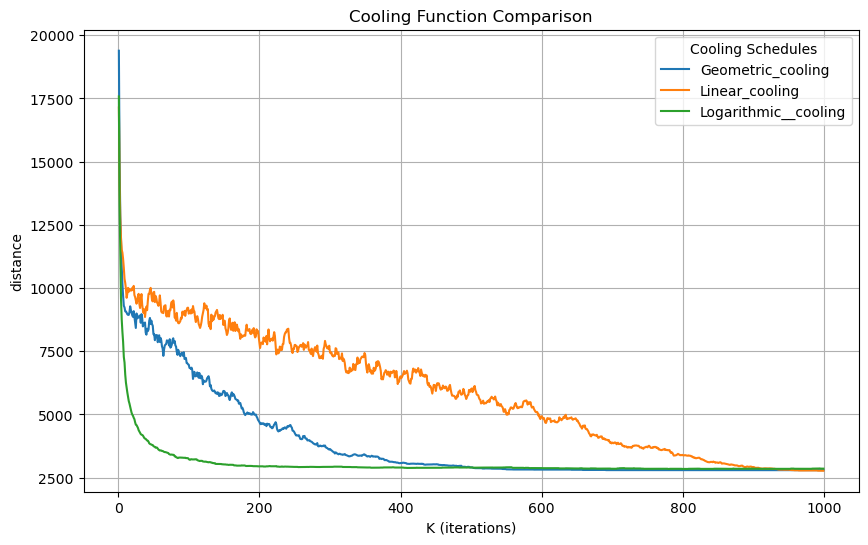

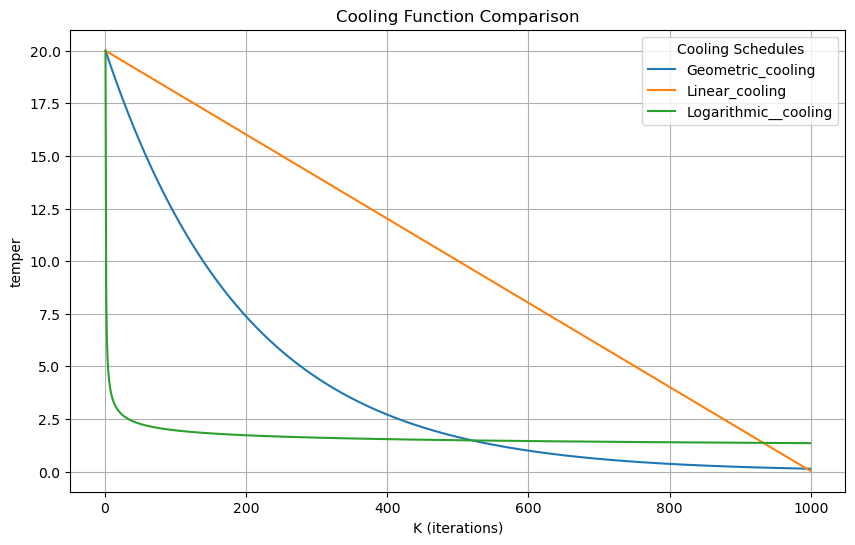

In [7]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

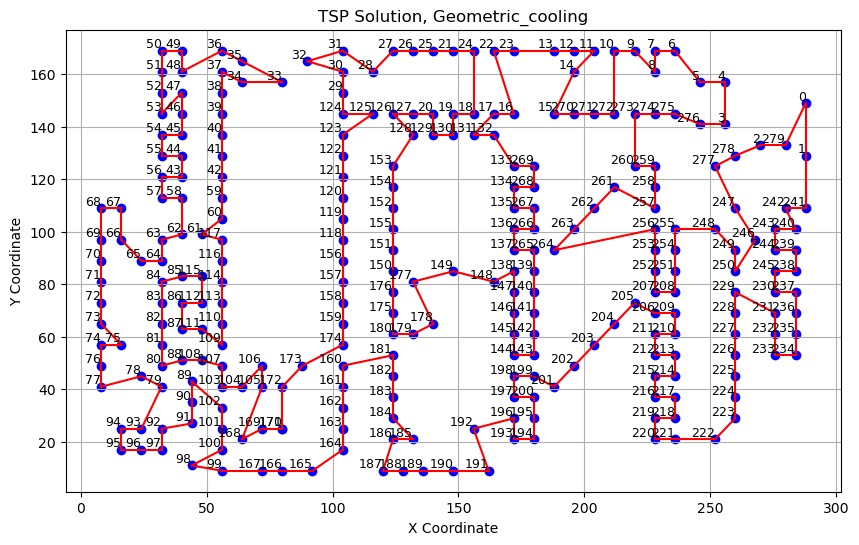

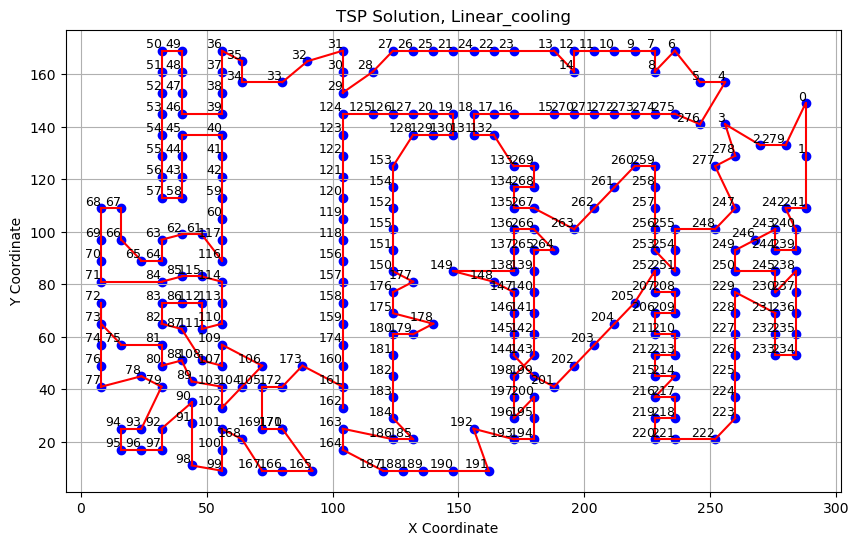

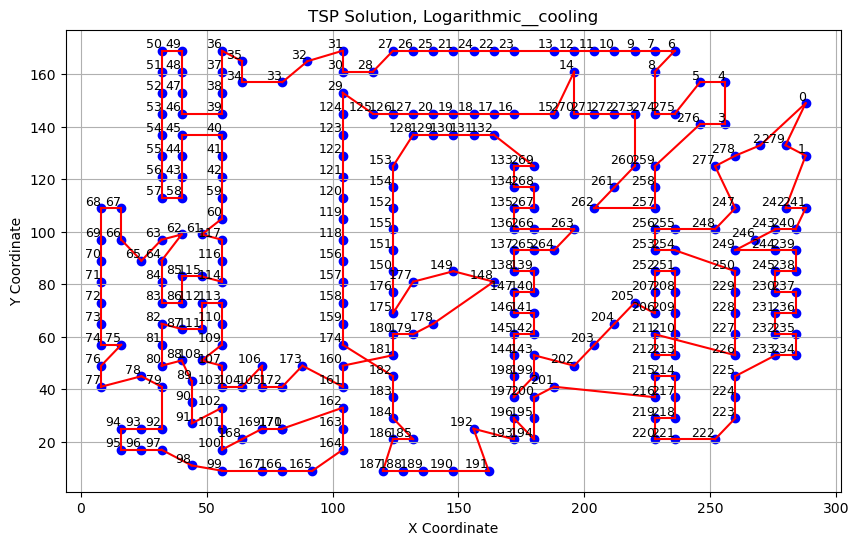

In [8]:
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

## Pre experiment

In [9]:
initial_temp = 10
max_iter = 1000
markov_chain_length = 50

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

1000
0.01000000000016889
Cooling_method_name: Linear_cooling
Optimal Route: [84, 83, 87, 81, 82, 75, 77, 76, 74, 73, 72, 70, 71, 65, 64, 63, 66, 69, 68, 57, 58, 43, 44, 42, 59, 60, 56, 40, 41, 39, 38, 47, 37, 35, 34, 33, 36, 49, 52, 51, 50, 48, 46, 53, 45, 54, 55, 67, 62, 61, 116, 117, 115, 112, 114, 113, 109, 108, 88, 80, 79, 78, 89, 102, 105, 172, 106, 173, 157, 156, 176, 158, 159, 174, 182, 183, 184, 180, 181, 179, 175, 178, 147, 146, 141, 142, 145, 198, 144, 143, 202, 140, 138, 148, 149, 177, 150, 151, 155, 118, 119, 120, 122, 121, 123, 152, 19, 18, 21, 24, 17, 131, 129, 20, 127, 28, 31, 32, 30, 29, 124, 26, 25, 27, 125, 126, 153, 154, 128, 130, 269, 270, 271, 15, 135, 134, 268, 267, 136, 137, 266, 265, 139, 264, 133, 132, 16, 272, 273, 274, 275, 276, 4, 1, 279, 2, 0, 3, 249, 246, 244, 245, 229, 250, 228, 227, 226, 225, 233, 234, 232, 236, 237, 238, 239, 243, 240, 241, 242, 247, 278, 277, 8, 6, 7, 5, 9, 10, 12, 11, 13, 23, 22, 14, 259, 258, 260, 261, 263, 262, 257, 255, 252, 253, 2

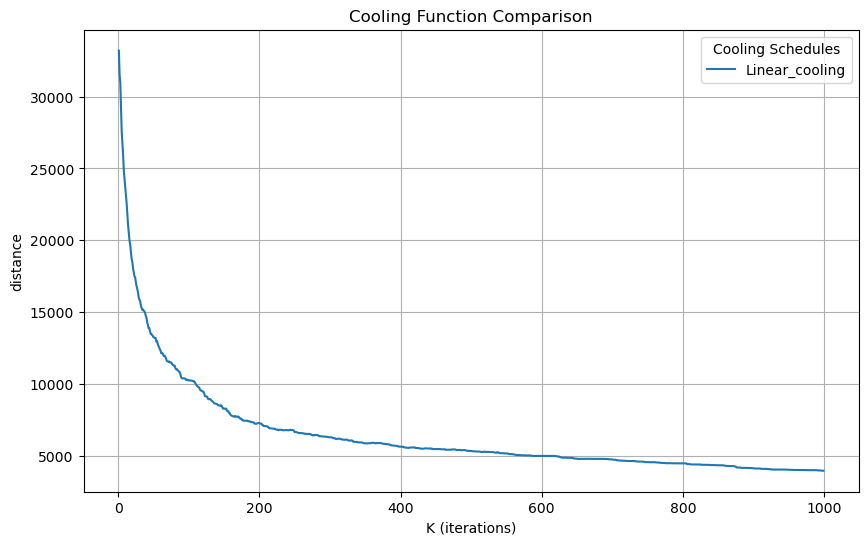

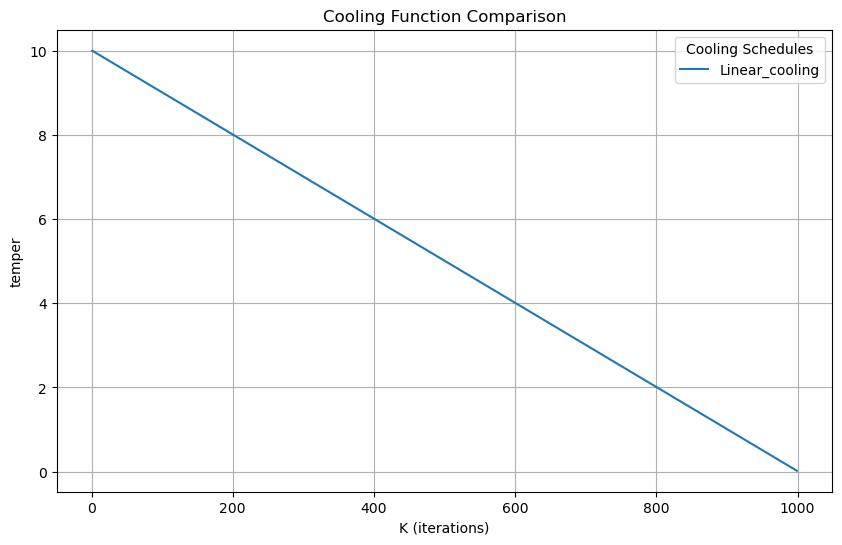

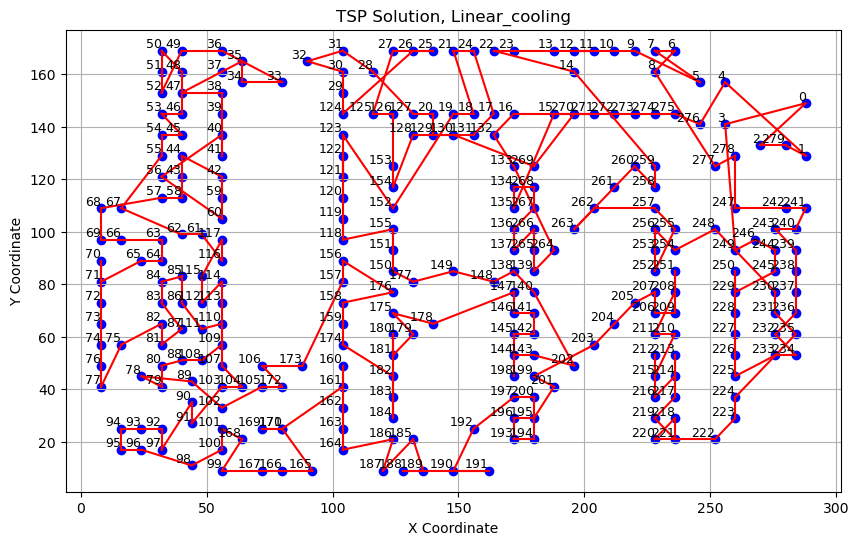

In [10]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

### Prove that a local minimum is obtained

In [11]:
best_route = optimal_route

In [12]:
def simulated_annealing_test_localmin(current_route, cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    current_distance = calculate_total_distance(cities, current_route)
    print(f"Current_distance : {current_distance}")
    temper = Temperature(Cooling_fuction, parameters)
    distance_iter = []
    temper_iter = []
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            #if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
            if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
        distance_iter.append((temper.iter,current_distance))     
        temper_iter.append((temper.iter,temper.current_temp))    
        temper.update_temperature()

    return current_route, current_distance, distance_iter, temper_iter

initial_temp = 10
max_iter = 10000
markov_chain_length = 10

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing_test_localmin(best_route, cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Optimal Route:", optimal_route)
    print("length of Optimal Route:", len(optimal_route))
    print("Optimal Distance:", optimal_distance)
    print()


Current_distance : 3981.949429226851
Optimal Route: [84, 85, 86, 82, 81, 75, 77, 76, 74, 73, 72, 71, 70, 65, 66, 69, 68, 67, 55, 54, 53, 46, 47, 48, 52, 51, 50, 49, 36, 35, 33, 34, 37, 38, 39, 40, 41, 42, 59, 60, 43, 44, 45, 56, 57, 58, 63, 64, 62, 61, 117, 116, 115, 114, 113, 112, 110, 109, 107, 103, 102, 104, 105, 106, 172, 173, 160, 174, 159, 175, 176, 177, 150, 151, 155, 149, 148, 138, 147, 140, 141, 146, 145, 178, 179, 180, 181, 182, 183, 184, 186, 185, 187, 188, 189, 190, 191, 192, 196, 193, 194, 195, 197, 200, 199, 198, 144, 142, 143, 201, 202, 203, 204, 205, 207, 252, 253, 256, 257, 263, 262, 261, 260, 258, 259, 273, 274, 275, 276, 3, 277, 278, 247, 249, 248, 255, 254, 251, 208, 209, 206, 211, 210, 213, 212, 215, 216, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 233, 234, 235, 236, 237, 238, 239, 230, 231, 232, 226, 227, 228, 229, 250, 245, 244, 246, 243, 240, 242, 241, 1, 0, 279, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 23, 22, 14, 272, 271, 270, 15, 269, 268, 135, 267, 266, 

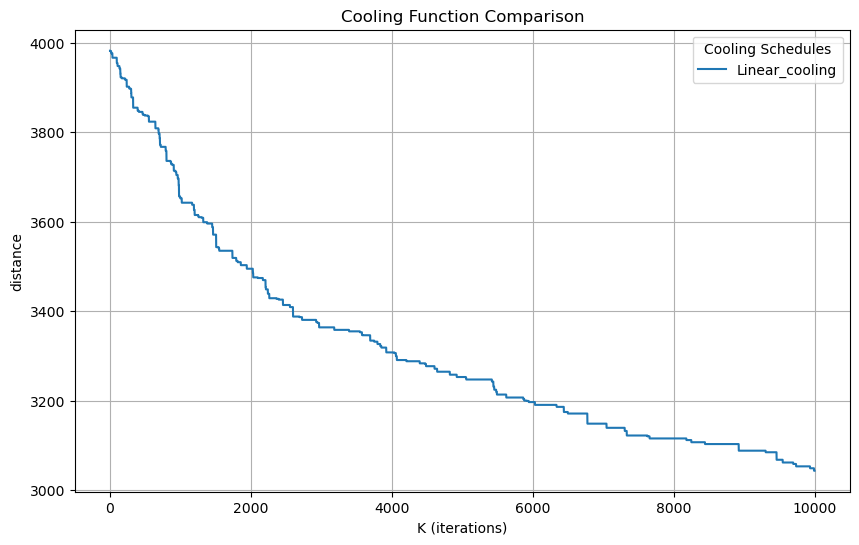

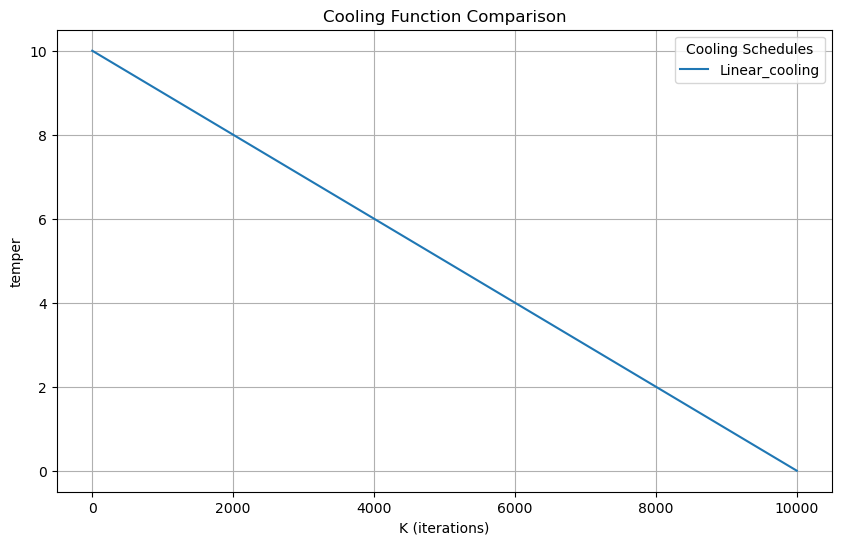

In [13]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

## Pre experiment Result:
The initial conditions are set as follows:

initial_temp = 10
max_iter = 1000
markov_chain_length = 200

## Cooling function
### Find the parameters setting for each cooling function

#### Geometric cooling function

In [46]:
geometric_initial_temps = [5,10,20]
geometric_cooling_rates = [0.995, 0.998, 0.9985,0.999,0.9999]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_geo = pd.DataFrame(columns=["Cooling_Rate", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for cooling_rate in geometric_cooling_rates:
    for geometric_initial_temp in geometric_initial_temps:
        for i in range(simulation_time):
            parameters_Geometric_cooling = {
                "cooling_method_name": "Geometric_cooling",
                "initial_temp": geometric_initial_temp, 
                "max_iter": max_iter,
                "markov_chain_length": markov_chain_length, 
                "cooling_rate": cooling_rate
            }
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Geometric_cooling, parameters_Geometric_cooling
            )

            # Append the results to the DataFrame
            results_df_geo = results_df_geo.append({
                "Cooling_Rate": cooling_rate,
                "Initial_Temp": geometric_initial_temp,
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resul

In [52]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_geo = results_df_geo.groupby(['Cooling_Rate', 'Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_geo = grouped_results_geo.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_geo.columns = ['_'.join(col).rstrip('_') for col in sorted_results.columns.values]
sorted_results_geo.to_excel('sorted_results_geo.xlsx', index=False)

By analyzing the result of sorted_results_geo, we can find the parameter setting of(**cooling rate = 0.9985, innitial temperature = 10**) with the smallest variance and third smallest mean.

#### Linear cooling function 

In [56]:
linear_initial_temps = [5,10,20]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_linear = pd.DataFrame(columns=["Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for linear_initial_temp in geometric_initial_temps:
    for i in range(simulation_time):
        parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                            "initial_temp" : linear_initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length}
        
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
            cities, two_opt_swap, Linear_cooling, parameters_Linear_cooling
        )

        # Append the results to the DataFrame
        results_df_linear = results_df_linear.append({
            "Initial_Temp": linear_initial_temp,
            "Simulation": i + 1,  # Simulation number (1 to simulation_time)
            "Optimal_Distance": optimal_distance,
            "Optimal_Route": optimal_route
        }, ignore_index=True)




/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [57]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_linear = results_df_linear.groupby(['Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_linear = grouped_results_linear.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_linear.columns = ['_'.join(col).rstrip('_') for col in sorted_results_linear.columns.values]
sorted_results_linear.to_excel('sorted_results_linear.xlsx', index=False)

The best result:
initial temp:5	mean:2757.06703

#### Logarithmic cooling function

In [ ]:
logarithmic_initial_temps = [5,10,20]
logarithmic_as = [1.5,2,2.5,3,3.5]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_log = pd.DataFrame(columns=["Logarithmic_a", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for logarithmic_a in logarithmic_as:
    for logarithmic_initial_temp in logarithmic_initial_temps:
        for i in range(simulation_time):
            parameters_Logarithmic__cooling = {"cooling_method_name" : "Logarithmic__cooling",
                                "initial_temp" : logarithmic_initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "a" : logarithmic_a}
            
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Logarithmic_cooling, parameters_Logarithmic__cooling
            )

            # Append the results to the DataFrame
            results_df_log = results_df_log.append({
                "Logarithmic_a": logarithmic_a,
                "Initial_Temp": logarithmic_initial_temp,
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)

# Save the DataFrame to a CSV file for later analysis and plotting
results_df_log.to_csv("simulated_annealing_results.csv", index=False)
print(results_df_log.head())  # Show the first few rows of the DataFrame

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resul

KeyboardInterrupt: 

In [50]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_log = results_df_log.groupby(['Logarithmic_a', 'Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_log = grouped_results_log.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_log.columns = ['_'.join(col).rstrip('_') for col in sorted_results.columns.values]
sorted_results_log.to_excel('sorted_results_log.xlsx', index=False)

This function is not used.

#### Basic cooling function

In [53]:
basic_bs = [10,40,90,160,250]
basic_as = [10,20,40,80]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_basic = pd.DataFrame(columns=["Cooling_Rate", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for baisc_a in basic_as:
    for basic_b in basic_bs:
        for i in range(simulation_time):
            parameters_Basic_cooling = {"cooling_method_name" : "Basic_cooling",
                            "initial_temp" : baisc_a/np.log(basic_b+1), 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : baisc_a, 
                            "b" : basic_b}
            
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Basic_cooling, parameters_Basic_cooling
            )

            # Append the results to the DataFrame
            results_df_basic = results_df_basic.append({
                "a": baisc_a,
                "b": basic_b,
                "Initial_Temp": baisc_a/np.log(basic_b+1),
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)

# Save the DataFrame to a CSV file for later analysis and plotting
results_df_basic.to_csv("simulated_annealing_results_basic.csv", index=False)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [55]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_basic = results_df_basic.groupby(['a', 'b']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_basic = grouped_results_basic.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_basic.columns = ['_'.join(col).rstrip('_') for col in sorted_results_basic.columns.values]
sorted_results_basic.to_excel('sorted_results_basic.xlsx', index=False)

By analyzing the result of sorted_results_basic, we can find the parameter setting of(**a=20, b=250**) with the smallest variance(622.1989305) and third smallest mean(2871.820567)

In [ ]:


# Function to compute sample mean and variance given a cooling schedule
def compute_statistics(temperatures):
    sample_mean = np.mean(temperatures)
    sample_variance = np.var(temperatures)
    return sample_mean, sample_variance

# Define parameters for the cooling functions
parameters = {
    "cooling_rate": 0.95,
    "initial_temp": 100,
    "max_iter": 1000,
    "a": 100,
    "b": 1.5
}

# Simulate annealing process for different cooling functions
geometric_temps = simulate_annealing(Geometric_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
linear_temps = simulate_annealing(Linear_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
logarithmic_temps = simulate_annealing(Logarithmic_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
basic_temps = simulate_annealing(Basic_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)

# Compute statistics for each cooling process
geometric_stats = compute_statistics(geometric_temps)
linear_stats = compute_statistics(linear_temps)
logarithmic_stats = compute_statistics(logarithmic_temps)
basic_stats = compute_statistics(basic_temps)

# Print out the results
print(f"Geometric cooling: Mean = {geometric_stats[0]}, Variance = {geometric_stats[1]}")
print(f"Linear cooling: Mean = {linear_stats[0]}, Variance = {linear_stats[1]}")
print(f"Logarithmic cooling: Mean = {logarithmic_stats[0]}, Variance = {logarithmic_stats[1]}")
print(f"Basic cooling: Mean = {basic_stats[0]}, Variance = {basic_stats[1]}")

# Plot the temperature descent for each cooling function
plt.plot(geometric_temps, label='Geometric Cooling')
plt.plot(linear_temps, label='Linear Cooling')
plt.plot(logarithmic_temps, label='Logarithmic Cooling')
plt.plot(basic_temps, label='Basic Cooling')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature Descent using Different Cooling Functions')
plt.legend()
plt.show()


# Comparing Cooling Functions with Optimal Parameters

In [15]:
import pandas as pd

# Parameters for the cooling methods
max_iter = 3000
markov_chain_length = 200

# Number of repetitions for each cooling method
n = 50

params_geometric_cooling = {"cooling_method_name" : "Geometric cooling",
                                "initial_temp" : 10, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": 0.9985}

params_linear_cooling = {"cooling_method_name" : "Linear cooling",
                                "initial_temp" : 5, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": None}

# params_logarithmic_cooling = {"cooling_method_name" : "Logarithmic cooling",
#                                 "initial_temp" : initial_temp, 
#                                 "max_iter": max_iter,
#                                 "markov_chain_length":markov_chain_length, 
#                                 "cooling_rate": cooling_rate}

params_basic_cooling = {"cooling_method_name" : "Basic cooling",
                            "initial_temp" : None, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : 20, 
                            "b" : 250}

params_basic_cooling['initial_temp'] = params_basic_cooling['a'] / np.log(params_basic_cooling['b'])

cooling_methods = [Geometric_cooling, Linear_cooling, Basic_cooling]
optimal_parameters = [params_geometric_cooling, params_linear_cooling, params_basic_cooling]

In [ ]:
# Compare the cooling methods using the optimal parameters, n times and store the results
# optimal_route, optimal_distance, distance_iter, temper_iter
import tqdm

results = []
optimal_routes = []

for cooling_method, parameters in zip(cooling_methods, optimal_parameters):
    for i in tqdm.tqdm(range(n), desc=f'Running {parameters["cooling_method_name"]}'):
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_method, parameters)
        distance_iter = [x[1] for x in distance_iter]
        temper_iter = [x[1] for x in temper_iter]
        optimal_routes.append(optimal_route)
        results.append({'cooling_method_name': parameters["cooling_method_name"], 'optimal_route': optimal_route, 'optimal_distance': optimal_distance, 'distance_iter': distance_iter, 'temper_iter': temper_iter})

df = pd.DataFrame(results)
df.to_csv(f'data/cooling_method_comparison_df_n={n}.csv', index=False)

### Boxplot comparison

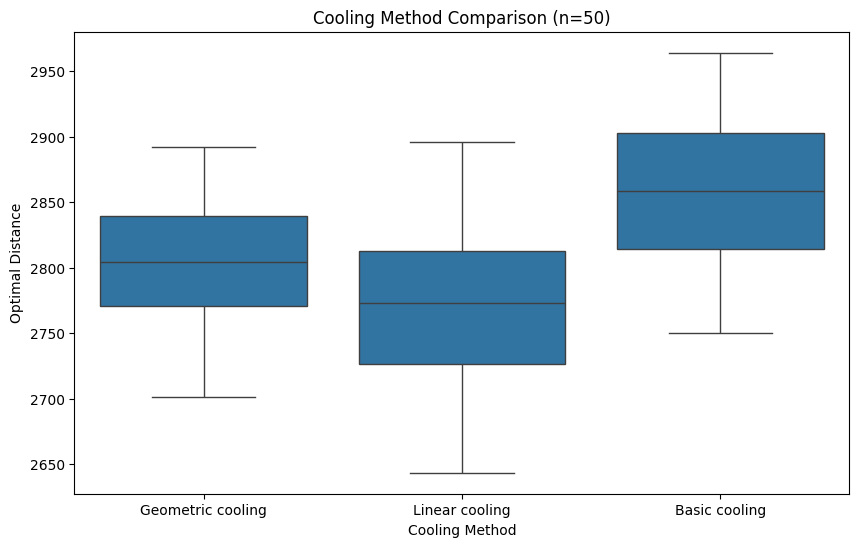

In [17]:
# Create a boxplot to compare the cooling methods: cooling method on x axis, optimal distance on y axis
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the csv file, columns distance_iter and temper_iter are lists of tuples
df = pd.read_csv('data/cooling_method_comparison_df_n=50.csv')

# Convert the string representation of the lists to actual lists
df['distance_iter'] = df['distance_iter'].apply(lambda x: eval(x))
df['temper_iter'] = df['temper_iter'].apply(lambda x: eval(x))

# Create a boxplot to compare the cooling methods
plt.figure(figsize=(10, 6))
sns.boxplot(x='cooling_method_name', y='optimal_distance', data=df)
plt.title(f'Cooling Method Comparison (n={n})')
plt.xlabel('Cooling Method')
plt.ylabel('Optimal Distance')
plt.show()

### Distance vs Iteration

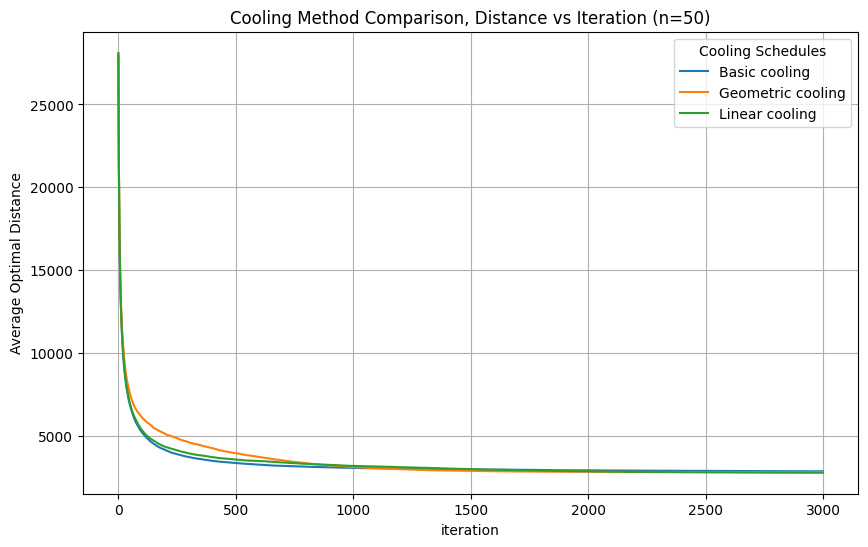

In [18]:
average_optimal_distance = df.groupby('cooling_method_name')['optimal_distance'].mean().reset_index()

# average_distance_iter = df.groupby('cooling_method_name')['distance_iter'].apply(lambda x: [tuple(map(lambda y: sum(y) / len(y), zip(*z))) for z in zip(*x)]).reset_index()
# Now distance_iter is just a list of values, not a list of tuples
average_distance_iter = df.groupby('cooling_method_name')['distance_iter'].apply(lambda x: [sum(y) / len(y) for y in zip(*x)]).reset_index()

# Merge the two DataFrames on 'cooling_method_name'
summary_df = pd.merge(average_optimal_distance, average_distance_iter, on='cooling_method_name')

# Rename columns for clarity
summary_df.columns = ['cooling_method_name', 'average_optimal_distance', 'average_distance_iter']

# Create a line plot to compare the cooling methods
plt.figure(figsize=(10, 6))
for cooling_method_name, average_distance_iter in zip(summary_df['cooling_method_name'], summary_df['average_distance_iter']):
    iters = list(range(len(average_distance_iter)))
    plt.plot(iters, average_distance_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Distance vs Iteration (n={n})')
plt.xlabel('iteration')
plt.ylabel('Average Optimal Distance')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()

### Distance vs Temperature

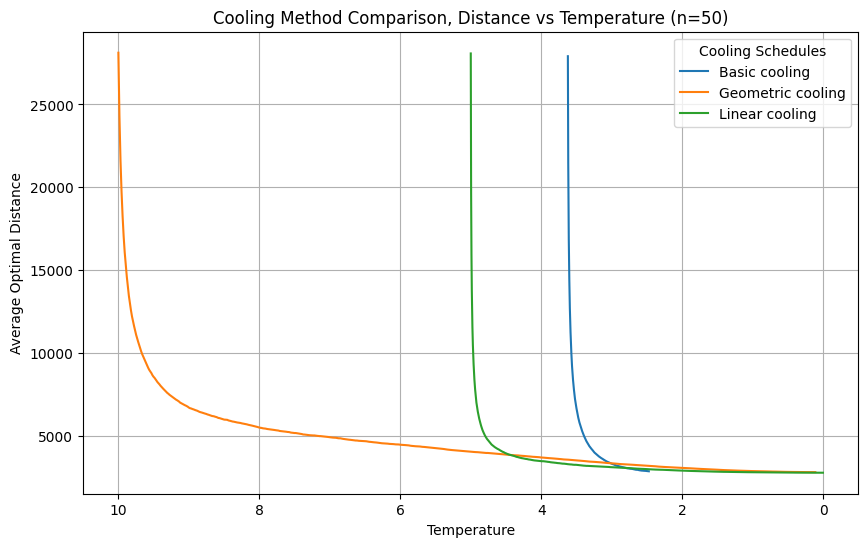

In [19]:
# Distance vs temperature
plt.figure(figsize=(10, 6))
for cooling_method_name, average_distance_iter in zip(summary_df['cooling_method_name'], summary_df['average_distance_iter']):
    iters = list(range(len(average_distance_iter)))
    temp_iters = df[df['cooling_method_name'] == cooling_method_name]['temper_iter'].iloc[0]
    plt.plot(temp_iters, average_distance_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Distance vs Temperature (n={n})')
plt.xlabel('Temperature')
# reverse x axis
plt.gca().invert_xaxis()
plt.ylabel('Average Optimal Distance')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()

### Temperature vs Iteration

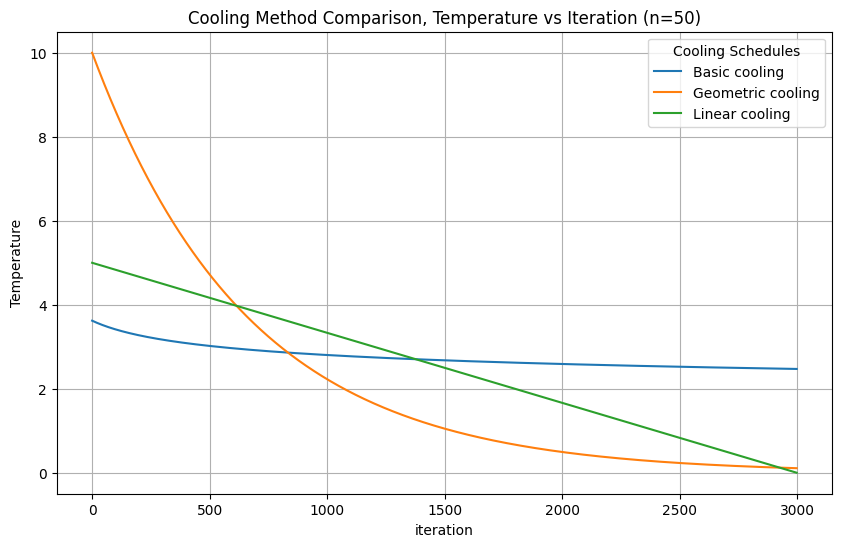

In [20]:
# Graph to plot the temperature against the iteration
# Since non-stochastic, can just look at first run of each cooling method
plt.figure(figsize=(10, 6))

# Iterate over the result DataFrame
for index, row in df.groupby('cooling_method_name')['temper_iter'].first().reset_index().iterrows():
    cooling_method_name = row['cooling_method_name']
    first_temper_iter = row['temper_iter']
    # print(f"Cooling Method: {cooling_method_name}, First Temper Iter: {first_temper_iter}")
    iters = list(range(len(first_temper_iter)))
    plt.plot(iters, first_temper_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Temperature vs Iteration (n={n})')
plt.xlabel('iteration')
plt.ylabel('Temperature')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()